In [1]:
import PySaRLAC as sl
import random
import math
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as pyplot
random.seed(1234)

In [2]:
f = h5py.File('raw_data.hdf5','r')

Lt=64
channels = [ sl.CorrelationFunction(Lt) for c in range(4) ]
chidx=0
for ch in ['elem_0', 'elem_1', 'elem_2', 'elem_3']:
    for t in range(Lt):
        enm = "elem_%d" % t        
        data = sl.RawDataDistribution(f["channels_raw"][ch]["series"][enm]["second"].attrs["data"])
        channels[chidx].setCoord(t,float(t))
        channels[chidx].setValue(t,data)
        print(ch,t,data)
    chidx+=1

elem_0 0 6376852.191588 +- 5534.945866
elem_0 1 6083539.140598 +- 4962.763933
elem_0 2 4407439.581022 +- 4121.671927
elem_0 3 3503178.283887 +- 3505.061142
elem_0 4 2833433.601845 +- 2980.331811
elem_0 5 2308583.462887 +- 2523.120028
elem_0 6 1886299.627537 +- 2118.743592
elem_0 7 1543639.184723 +- 1796.193690
elem_0 8 1264020.162040 +- 1526.891699
elem_0 9 1035432.489642 +- 1295.589476
elem_0 10 848460.097639 +- 1109.522460
elem_0 11 695157.174435 +- 951.012471
elem_0 12 569699.357004 +- 822.619745
elem_0 13 466914.007317 +- 712.018462
elem_0 14 382716.768421 +- 616.544918
elem_0 15 313775.694506 +- 537.470403
elem_0 16 257330.588899 +- 469.413614
elem_0 17 211044.497133 +- 410.524620
elem_0 18 173204.624511 +- 360.385813
elem_0 19 142203.392826 +- 316.601905
elem_0 20 116860.296722 +- 279.798467
elem_0 21 96172.375632 +- 248.180820
elem_0 22 79308.464255 +- 220.185858
elem_0 23 65597.747621 +- 197.396250
elem_0 24 54482.491078 +- 177.304103
elem_0 25 45531.191207 +- 160.963423
elem_0

In [3]:
#Channel average
data = sl.CorrelationFunction(Lt)
for t in range(Lt):
    data.setCoord(t,float(t))
    avg = ( channels[0].value(t) + channels[1].value(t) + channels[2].value(t) + channels[3].value(t) ) / 4.
    data.setValue(t,avg)


In [4]:
#Fold the data
data_fold = data.fold()

In [5]:
jack = data_fold.resample(sl.JackknifeDistribution)

In [6]:
ef = sl.EffMassCosh(Lt)
effmass = sl.effectiveMass(jack,ef)

/home/idies/workspace/Storage/ckelly/persistent/conda/conda_envs/c4m/lib/python3.13/site-packages/PySaRLAC/EffectiveMass.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  r = opt.curve_fit(ff, [x], [y], p0=[0.5], jac=dd)


(0.5, 32.5)

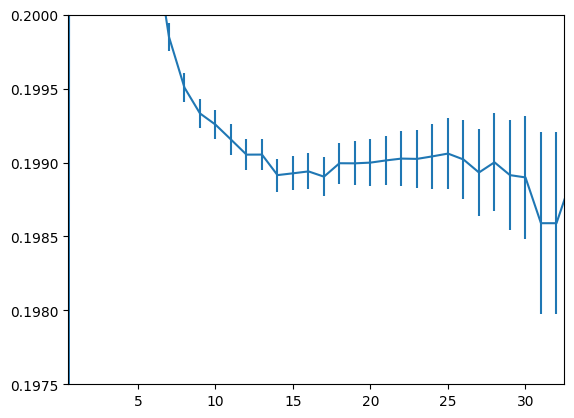

In [8]:
effmass_plt = effmass.plotInputs()
pyplot.errorbar(effmass_plt[0],effmass_plt[1],yerr=effmass_plt[2])
pyplot.ylim(0.1975,0.200)
pyplot.xlim(0.5,32.5)

In [9]:

djack = data_fold.resample(sl.DoubleJackknifeDistribution)


In [10]:
fit_start = 14
fit_end = 29
jack_inrange = jack.sliceRange(fit_start,fit_end)
djack_inrange = djack.sliceRange(fit_start,fit_end)


In [11]:
fitfunc = sl.FitCosh(Lt)

In [12]:
fitter = sl.Fitter(fitfunc)

In [13]:
fitter.generateCovarianceMatrix(djack_inrange)

In [14]:
N=741
params = [sl.JackknifeDistribution(N,6e6), sl.JackknifeDistribution(N,0.2)]

In [15]:
chisq, dof = fitter.fit(params, jack_inrange )

Performing a fit with 2 free parameters and 14 degrees of freedom


In [16]:
chisq.mean()/dof

np.float64(0.3578394694881225)

In [17]:
print(params[0],params[1])

6194275.446589 +- 8829.568393 0.198933 +- 0.000112


(0.5, 32.5)

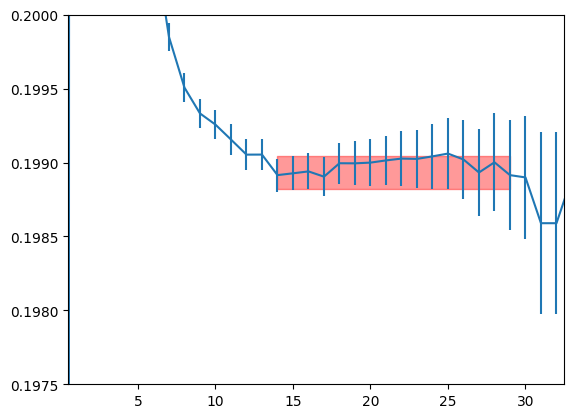

In [18]:
pyplot.errorbar(effmass_plt[0],effmass_plt[1],yerr=effmass_plt[2])
fmu = params[1].mean()
fsig = params[1].standardError()
pyplot.fill_between([t for t in range(fit_start, fit_end+1)], fmu-fsig, fmu+fsig, color='r', alpha=0.4)
pyplot.ylim(0.1975,0.200)
pyplot.xlim(0.5,32.5)